In [1]:
pip install -U pandas-profiling

     |████████████████████████████████| 133kB 2.8MB/s 
     |████████████████████████████████| 614kB 52.2MB/s 
     |████████████████████████████████| 235kB 52.5MB/s 
     |████████████████████████████████| 307kB 62.3MB/s 
     |████████████████████████████████| 51kB 8.0MB/s 
     |████████████████████████████████| 215kB 62.3MB/s 
     |████████████████████████████████| 737kB 53.2MB/s 
     |████████████████████████████████| 61kB 9.1MB/s 
  Created wheel for pandas-profiling: filename=pandas_profiling-2.3.0-py2.py3-none-any.whl size=145035 sha256=1aa63e6b3476955a7954fa7083a933fff5750cc6108a43e24bcc1a7f11fe11ae
  Stored in directory: /root/.cache/pip/wheels/ce/c7/f1/dbfef4848ebb048cb1d4a22d1ed0c62d8ff2523747235e19fe
  Created wheel for htmlmin: filename=htmlmin-0.1.12-cp36-none-any.whl size=27084 sha256=5bbd3a8b9bd2a3d5b394d350bc0866fc67a2affba1807b93bdba49a2c1e6ccd3
  Stored in directory: /root/.cache/pip/wheels/43/07/ac/7c5a9d708d65247ac1f94066cf1db075540b85716c30255459
  Created whee

In [0]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import pandas_profiling
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
import numpy as np
import warnings
from sklearn import preprocessing
from statistics import mean
from statistics import pvariance
from sklearn.model_selection import KFold
from sklearn import metrics
from tabulate import tabulate
import sys
warnings.filterwarnings('ignore')

In [0]:
df = pd.read_csv("https://raw.githubusercontent.com/AgnaldoCC/3_estagio_cdp/master/train.csv")

# **1. Realize uma análise exploratória nos dados, identificando e explorando**

*   Correlações entre as variáveis;
*   Checar distribuição das variáveis;
*   Checar distribuição das classes.




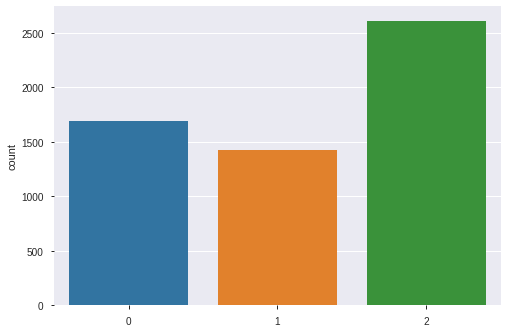

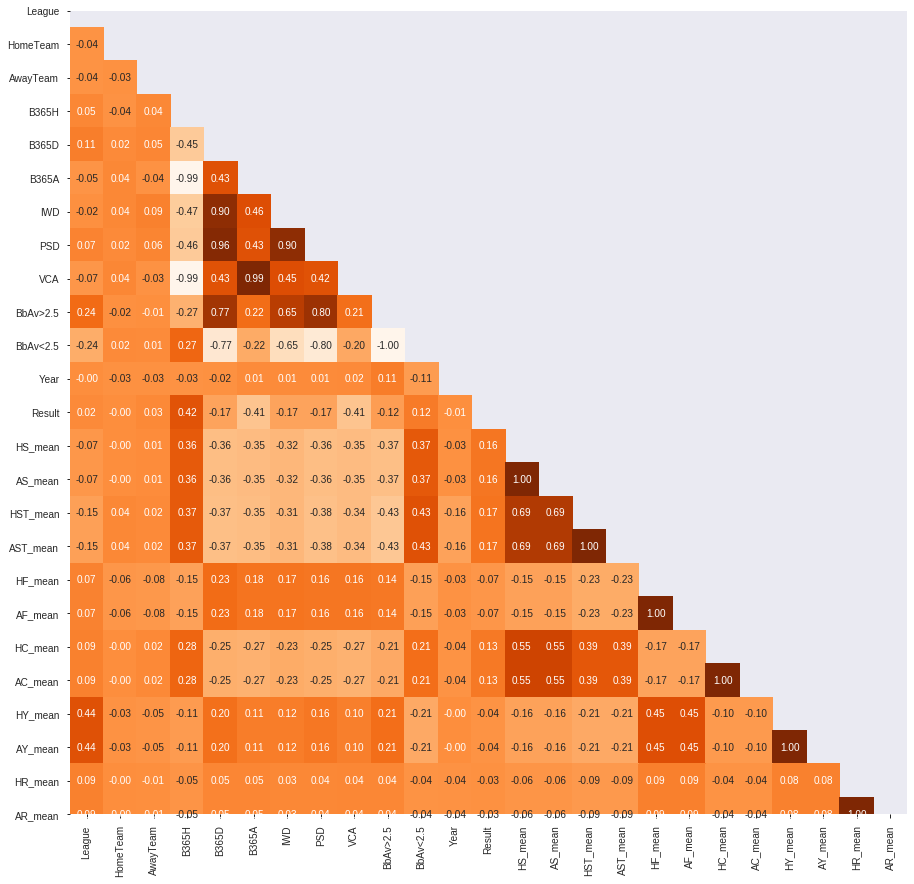

In [21]:
l = preprocessing.LabelEncoder()

l.fit(df.AwayTeam.values.tolist() + df.HomeTeam.values.tolist())

df['AwayTeam'] = l.transform(df.AwayTeam.values.tolist())
df['HomeTeam'] = l.transform(df.HomeTeam.values.tolist())

df['League'] = df['League'].replace(['Germany', 'England', 'Italy', 'Spain'], [0, 1, 2, 3])

colunasRemoviveis = ['WHH', 'WHD', 'WHA', 'VCH', 'VCD', 'PSH', 'PSA', 'LBH', 'LBD', 'LBA', 'IWH', 'IWA', 'HY', 'HR', 'BWH', 'BWD', 'BWA', 'BbMx>2.5', 'BbMx<2.5', 'ID', 'Date']

colunasEstatisticas = ['HS', 'AS', 'HST', 'AST', 'HF', 'AF', 'HC', 'AC', 'HY', 'AY', 'HR', 'AR']

for coluna in colunasEstatisticas:
  df[coluna + '_mean'] = df[[coluna]].apply(lambda x: round(mean(list(map(float, x[0][1:-1].split(','))))), axis=1)

df = df.drop(columns=colunasEstatisticas + colunasRemoviveis)
df = pd.get_dummies(df)

x = df.loc[:, df.columns != 'Result']
y = df.Result.values

sns.countplot(y)

corr = df.corr(method='spearman')
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

fig, ax = plt.subplots()
ax.figure.set_size_inches(15, 15)
sns.heatmap(corr, ax=ax, annot=True, mask=mask, fmt='.2f', cbar=False, square=True, cmap=plt.cm.Oranges, center=0)

In [0]:
#Removendo colunas com muita correlação
df = df.drop(columns=['HC_mean', 'HF_mean', 'HR_mean', 'HS_mean', 'HST_mean', 'HY_mean', 'VCA'])

# **2. Tune, usando validação cruzada e outras medidas para controlar o overfitting caso necessário:**

*   Um modelo de classificação com Regressão Logística,
*   Um modelo de classificação com Árvores de Decisão,
*   Um modelo KNN,
*   Um modelo usando AdaBoost.

Text(0, 0.5, 'Acurácia')

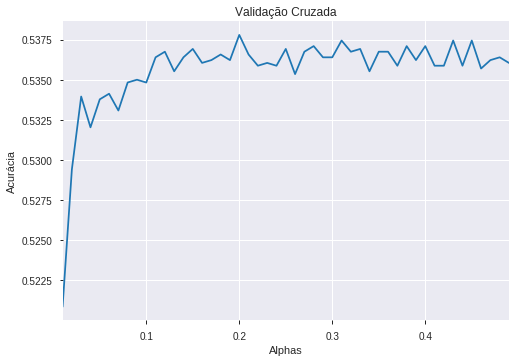

In [26]:
def report(model, x, y):
  return cross_val_score(model, x, y, scoring='accuracy', cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=7001), n_jobs = -1)


#Regressão Logística
alphas = np.arange(0.01,0.5,0.01).tolist()

reg_logistica = [report(LogisticRegression(solver="lbfgs", max_iter=10000, C=alpha), x, y).mean()
                    for alpha in alphas]

logistica = pd.Series(reg_logistica, index = alphas)
logistica.plot(title = "Validação Cruzada")
plt.xlabel("Alphas")
plt.ylabel("Acurácia")

Text(0, 0.5, 'Acurácia')

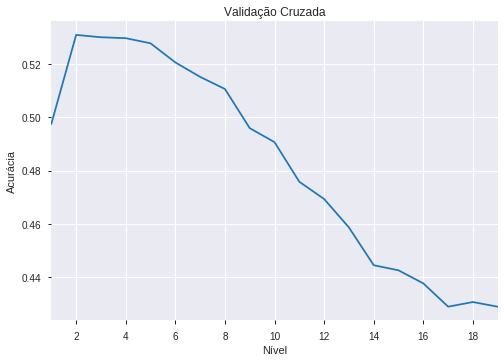

In [28]:
#Árvores de decisão
niveis = np.arange(1,20,1).tolist()
tree = [report(DecisionTreeClassifier(max_depth = nivel),
                x,
                y).mean() 
            for nivel in niveis]
tree = pd.Series(tree, index = niveis)

tree.plot(title = "Validação Cruzada")
plt.xlabel("Nível")
plt.ylabel("Acurácia")



Text(0, 0.5, 'Acurácia')

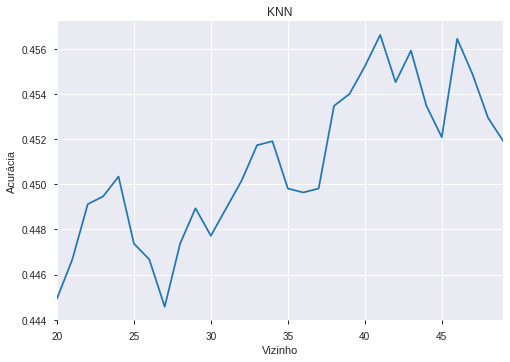

In [41]:
#KNN
vizinhos = np.arange(20,50,1).tolist()

knn_aux = [report(KNeighborsClassifier(n_neighbors=vizinho), x, y).mean()
                    for vizinho in vizinhos]

knn = pd.Series(knn_aux, index = vizinhos)
knn.plot(title = "KNN")
plt.xlabel("Vizinho")
plt.ylabel("Acurácia")



Text(0, 0.5, 'Acurácia')

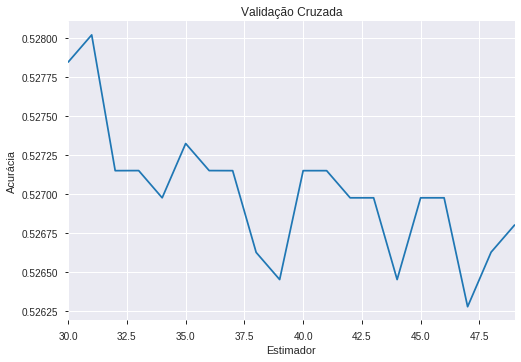

In [33]:
#Usando AdaBoost
estimadores = np.arange(30,50,1).tolist()
ada =  [report(AdaBoostClassifier(DecisionTreeClassifier(max_depth=tree.idxmax()), 
                                    algorithm="SAMME", 
                                    n_estimators=estimador), x, y).mean() for estimador in estimadores]

ada = pd.Series(ada, index = estimadores)
ada.plot(title = "Validação Cruzada")
plt.xlabel("Estimador")
plt.ylabel("Acurácia")

# **3. Identifique os valores de Precision, Recall, Acurácia e F1-Score para os modelos utilizados. Existe diferença entre o desempenho no treino e na validação? Justifique os resultados obtidos.**

In [42]:
def validacao_treino(modelo,x,y):
    kf = KFold(n_splits=5, shuffle=True)
    for train_index, validation_index in kf.split(df):
      modelo.fit(x.iloc[train_index], y[train_index])
    
      pred_treino = modelo.predict(x.iloc[train_index])
      treino = metrics.classification_report(y[train_index], pred_treino, output_dict=True)["macro avg"]
      treino['accuracy'] = metrics.accuracy_score(y[train_index], pred_treino)
      
      pred_validacao = modelo.predict(x.iloc[validation_index])
      validacao = metrics.classification_report(y[validation_index], pred_validacao, 
                                                        output_dict=True)["macro avg"]
      validacao['accuracy'] = metrics.accuracy_score(y[validation_index], pred_validacao)                                                  
      
      del treino['support']
      del validacao['support']
      metricas_treino =  treino.values()
      metricas_validacao = validacao.values()
      metricas = {'Valores': ['Precisão', 'Recall', 'Score-F1', 'Acurácia'], 'Treino': metricas_treino, 'Validação': metricas_validacao}
      print(tabulate(metricas , headers='keys', tablefmt='fancy_grid'))
      return 

arvore = DecisionTreeClassifier(max_depth = tree.idxmax())
print("Árvore de decisão")
validacao_treino(arvore, x, y)

print('------------------------------')

regressao = LogisticRegression(solver="lbfgs", max_iter=10000, C=logistica.idxmax())
print("Regressão Logística")
validacao_treino(regressao, x, y)

print('------------------------------')

knn_result = KNeighborsClassifier(n_neighbors = knn.idxmax())
print("KNN")
validacao_treino(knn_result, x, y)

print('------------------------------')

# Lembrando: Utilizando o melhor parâmetro estimado com validação cruzada da árvore de decisão pra definir o max_depth
ada = AdaBoostClassifier(DecisionTreeClassifier(max_depth=tree.idxmax()), 
                                    algorithm="SAMME", 
                                    n_estimators=ada.idxmax())
print("AdaBoost")
validacao_treino(ada, x, y)

Árvore de decisão
╒═══════════╤══════════╤═════════════╕
│ Valores   │   Treino │   Validação │
╞═══════════╪══════════╪═════════════╡
│ Precisão  │ 0.368972 │    0.386159 │
├───────────┼──────────┼─────────────┤
│ Recall    │ 0.425527 │    0.431963 │
├───────────┼──────────┼─────────────┤
│ Score-F1  │ 0.365433 │    0.375497 │
├───────────┼──────────┼─────────────┤
│ Acurácia  │ 0.52542  │    0.541885 │
╘═══════════╧══════════╧═════════════╛
------------------------------
Regressão Logística
╒═══════════╤══════════╤═════════════╕
│ Valores   │   Treino │   Validação │
╞═══════════╪══════════╪═════════════╡
│ Precisão  │ 0.481495 │    0.490181 │
├───────────┼──────────┼─────────────┤
│ Recall    │ 0.451203 │    0.474442 │
├───────────┼──────────┼─────────────┤
│ Score-F1  │ 0.407401 │    0.431969 │
├───────────┼──────────┼─────────────┤
│ Acurácia  │ 0.529566 │    0.568063 │
╘═══════════╧══════════╧═════════════╛
------------------------------
KNN
╒═══════════╤══════════╤═════════════╕

Como pode-se observar, os dados de treino foram melhores para todos os modelos propostos.